<a href="https://colab.research.google.com/github/noornabeelak/Mini-Project/blob/main/jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio transformers scikit-learn nltk tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import nltk
from tqdm import tqdm
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import random
import re
import os
import requests

nltk.download('punkt')
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


/usr/local/lib/python3.12/dist-packages/torch_xla/experimental/gru.py:113: SyntaxWarning: invalid escape sequence '\_'
  * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or
/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
import nltk
nltk.download('punkt_tab')

os.makedirs("data", exist_ok=True)

# Example authentic open-domain sources (public domain)
sources = [
    "https://www.gutenberg.org/cache/epub/20417/pg20417.txt",  # The Science of Being Well
    "https://www.gutenberg.org/cache/epub/10/pg10.txt",         # King James Bible (general linguistic structure)
    "https://www.gutenberg.org/cache/epub/4300/pg4300.txt",     # The Republic by Plato
]

real_texts = []
for url in sources:
    text = requests.get(url).text
    text = re.sub(r'\s+', ' ', text)
    paras = nltk.sent_tokenize(text)
    real_texts.extend(paras[:1500])  # moderate size

def fabricate_text(paragraph):
    words = paragraph.split()
    random.shuffle(words)
    if len(words) > 5:
        words[random.randint(0, len(words)-1)] = "syntheticized"
    return " ".join(words)

fake_texts = [fabricate_text(p) for p in random.sample(real_texts, 1500)]

with open("data/authentic.txt", "w") as f:
    for t in real_texts:
        f.write(t + "\n")

with open("data/fake.txt", "w") as f:
    for t in fake_texts:
        f.write(t + "\n")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

class TextDataset(Dataset):
    def __init__(self, real_path, fake_path):
        self.samples = []
        with open(real_path, 'r') as f:
            for line in f:
                self.samples.append((line.strip(), 1))
        with open(fake_path, 'r') as f:
            for line in f:
                self.samples.append((line.strip(), 0))
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text, label = self.samples[idx]
        enc = tokenizer(
            text, truncation=True, padding='max_length',
            max_length=64, return_tensors='pt'
        )
        return enc['input_ids'].squeeze(0), enc['attention_mask'].squeeze(0), torch.tensor(label)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [5]:
dataset = TextDataset("data/authentic.txt", "data/fake.txt")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)


In [6]:
class Generator(nn.Module):
    def __init__(self, noise_dim=768):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 768),
            nn.LeakyReLU(0.2),
            nn.Linear(768, 768),
        )
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(768, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)


In [7]:
bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
bert.eval()  # freeze during GAN pretraining

G = Generator()
D = Discriminator()
criterion = nn.BCELoss()
opt_D = optim.Adam(D.parameters(), lr=1e-4)
opt_G = optim.Adam(G.parameters(), lr=1e-4)

for epoch in range(3):  # pretrain 3 epochs
    for input_ids, att_mask, labels in tqdm(train_loader):
        with torch.no_grad():
            real_embeddings = bert(input_ids, attention_mask=att_mask).last_hidden_state.mean(dim=1)

        batch_size = real_embeddings.size(0)
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # --- Train Discriminator ---
        opt_D.zero_grad()
        real_output = D(real_embeddings)
        loss_real = criterion(real_output, real_labels)

        z = torch.randn(batch_size, 768)
        fake_embeddings = G(z)
        fake_output = D(fake_embeddings.detach())
        loss_fake = criterion(fake_output, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        opt_D.step()

        # --- Train Generator ---
        opt_G.zero_grad()
        output = D(fake_embeddings)
        loss_G = criterion(output, real_labels)
        loss_G.backward()
        opt_G.step()

    print(f"Epoch {epoch+1}: D_loss={loss_D.item():.4f}, G_loss={loss_G.item():.4f}")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

100%|██████████| 150/150 [02:24<00:00,  1.04it/s]


Epoch 1: D_loss=0.4353, G_loss=2.5965


100%|██████████| 150/150 [02:08<00:00,  1.17it/s]


Epoch 2: D_loss=0.0924, G_loss=4.5514


100%|██████████| 150/150 [02:06<00:00,  1.19it/s]

Epoch 3: D_loss=0.1751, G_loss=3.5214


In [8]:
class AuthentiClassifier(nn.Module):
    def __init__(self, discriminator):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.discriminator = discriminator
    def forward(self, input_ids, attention_mask):
        embeddings = self.bert(input_ids, attention_mask=attention_mask).last_hidden_state.mean(dim=1)
        return self.discriminator(embeddings)

clf = AuthentiClassifier(D)
optimizer = optim.Adam(clf.parameters(), lr=2e-5)
loss_fn = nn.BCELoss()


100%|██████████| 150/150 [07:19<00:00,  2.93s/it]



Epoch 1/3
Accuracy: 0.9817 | Precision: 0.9766 | Recall: 0.9989 | F1: 0.9876 | AUC: 0.9667


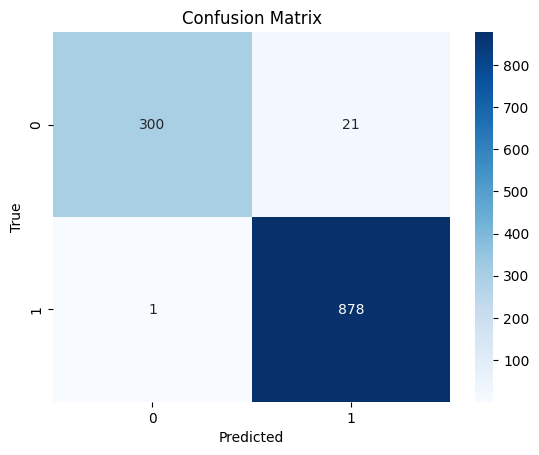

 83%|████████▎ | 125/150 [06:01<01:12,  2.91s/it]

In [ ]:
def evaluate(model, loader):
    model.eval()
    preds, labels_list = [], []
    with torch.no_grad():
        for input_ids, att_mask, labels in loader:
            out = model(input_ids, att_mask)
            preds.extend((out.squeeze() > 0.5).int().tolist())
            labels_list.extend(labels.tolist())
    acc = accuracy_score(labels_list, preds)
    prec = precision_score(labels_list, preds)
    rec = recall_score(labels_list, preds)
    f1 = f1_score(labels_list, preds)
    auc = roc_auc_score(labels_list, preds)
    cm = confusion_matrix(labels_list, preds)
    return acc, prec, rec, f1, auc, cm

EPOCHS = 3
for epoch in range(EPOCHS):
    clf.train()
    for input_ids, att_mask, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = clf(input_ids, att_mask)
        loss = loss_fn(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

    acc, prec, rec, f1, auc, cm = evaluate(clf, val_loader)
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
